## Investigate YoY decline in revert rate in 2019

From April 2019, there was a large (>30%) YoY decline in revert rate. We'd like to look into possible reasons for this yoy decline.

Revert rate: The proportion of non-bot edits made during the given month which were reverted at any point before the snapshot.

**Approach and questions**
- Is it project specific or universal?
- Is it correlated to edit increase?
- Is it correlated to user tenure status?
- Micro contribution
- (more to add..)

In [10]:
shhh <- function(expr) suppressPackageStartupMessages(suppressWarnings(suppressMessages(expr)))
shhh({
    library(tidyverse); library(ggplot2); library(lubridate); library(scales); library(reshape2);
    library(wmf);library(dplyr);library(cowplot)
})

In [26]:
query <- "
SELECT
    month,
    SUM(CAST(nonbot_edit AS int)) AS nonbot_edit,
    SUM(CAST(reverted AS int)) AS revert
FROM (
    SELECT
        wiki_db,
        DATE_FORMAT(event_timestamp, 'YYYY-MM-01') AS month,
        SIZE(event_user_is_bot_by) = 0 and SIZE(event_user_is_bot_by_historical) = 0 AS nonbot_edit,
        revision_is_identity_reverted AS reverted
    FROM wmf.mediawiki_history
    WHERE
        event_entity = 'revision'
        AND event_type = 'create'
        AND event_timestamp > '2017-06' 
        AND event_timestamp < '2019-09'
        AND snapshot = '2019-08'
) edits
GROUP BY wiki_db, month
"

In [27]:
revert_all <- wmf::query_hive(query)
revert_all$month <- as.Date(revert_all$month,'%Y-%m-%d')

In [28]:
revert_rate_month <- revert_all %>%
  filter(month <= '2019-08-01') %>%
  group_by(month) %>%
  summarise(monthly_edit = sum(nonbot_edit),monthly_revert = sum(revert)) %>% 
  mutate (revert_rate = monthly_revert/monthly_edit) %>% 
  mutate(yoy_percent = (revert_rate/lag(revert_rate,12) -1) *100)

tail(revert_rate_month,10)

month,monthly_edit,monthly_revert,revert_rate,yoy_percent
<date>,<int>,<int>,<dbl>,<dbl>
2018-11-01,19314248,1861270,0.09636772,-9.837738
2018-12-01,19973309,1789524,0.08959577,-17.786642
2019-01-01,25515161,2159251,0.08462620,-26.099841
2019-02-01,23029508,1800933,0.07820111,-21.269797
2019-03-01,28962449,1972019,0.06808882,-21.796816
2019-04-01,27159829,1784167,0.06569139,-36.451064
2019-05-01,27155176,1824323,0.06718141,-30.486790
2019-06-01,23080439,1478565,0.06406139,-34.016478
2019-07-01,22910916,1362772,0.05948134,-38.923967


### Revert Rate by Wiki

In [20]:
query <- "
SELECT
    wiki_db,
    month,
    SUM(CAST(nonbot_edit AS int)) AS nonbot_edit,
    SUM(CAST(reverted AS int)) AS revert
FROM (
    SELECT
        wiki_db,
        DATE_FORMAT(event_timestamp, 'YYYY-MM-01') AS month,
        SIZE(event_user_is_bot_by) = 0 and SIZE(event_user_is_bot_by_historical) = 0 AS nonbot_edit,
        revision_is_identity_reverted AS reverted
    FROM wmf.mediawiki_history
    WHERE
        event_entity = 'revision'
        AND event_type = 'create'
        AND event_timestamp > '2016-06' 
        AND event_timestamp < '2019-09'
        AND snapshot = '2019-08'
        AND wiki_db in ('enwiki','commonswiki','wikidatawiki','eswiki', 'dewiki', 'jawiki', 'frwiki', 'ruwiki','itwiki','zhwiki','ptwiki', 'plwiki', 'nlwiki')

) edits
GROUP BY wiki_db, month
"

In [21]:
revert_wiki <- wmf::query_hive(query)

In [24]:
revert_wiki$month <- as.Date(revert_wiki$month,'%Y-%m-%d')

In [20]:
revert_rate_fy <- revert_wiki %>%
    filter(month >= '2017-07-01') %>%
    mutate(revert_rate = revert/nonbot_edit) %>%
    mutate(fiscal_year = ifelse(month >= '2017-07-01' & month < '2018-07-01', 'FY 2017/18', ifelse(month <'2019-07-01','FY 2018/19','FY 2019/20')),
    MonthN =as.factor(format(as.Date(month),"%m")),Month = months(as.Date(month), abbreviate=TRUE))

revert_rate_fy$MonthN = factor(revert_rate_fy$MonthN, levels=c("07","08", "09", "10", "11", "12", "01", "02", "03", "04", "05", "06"))



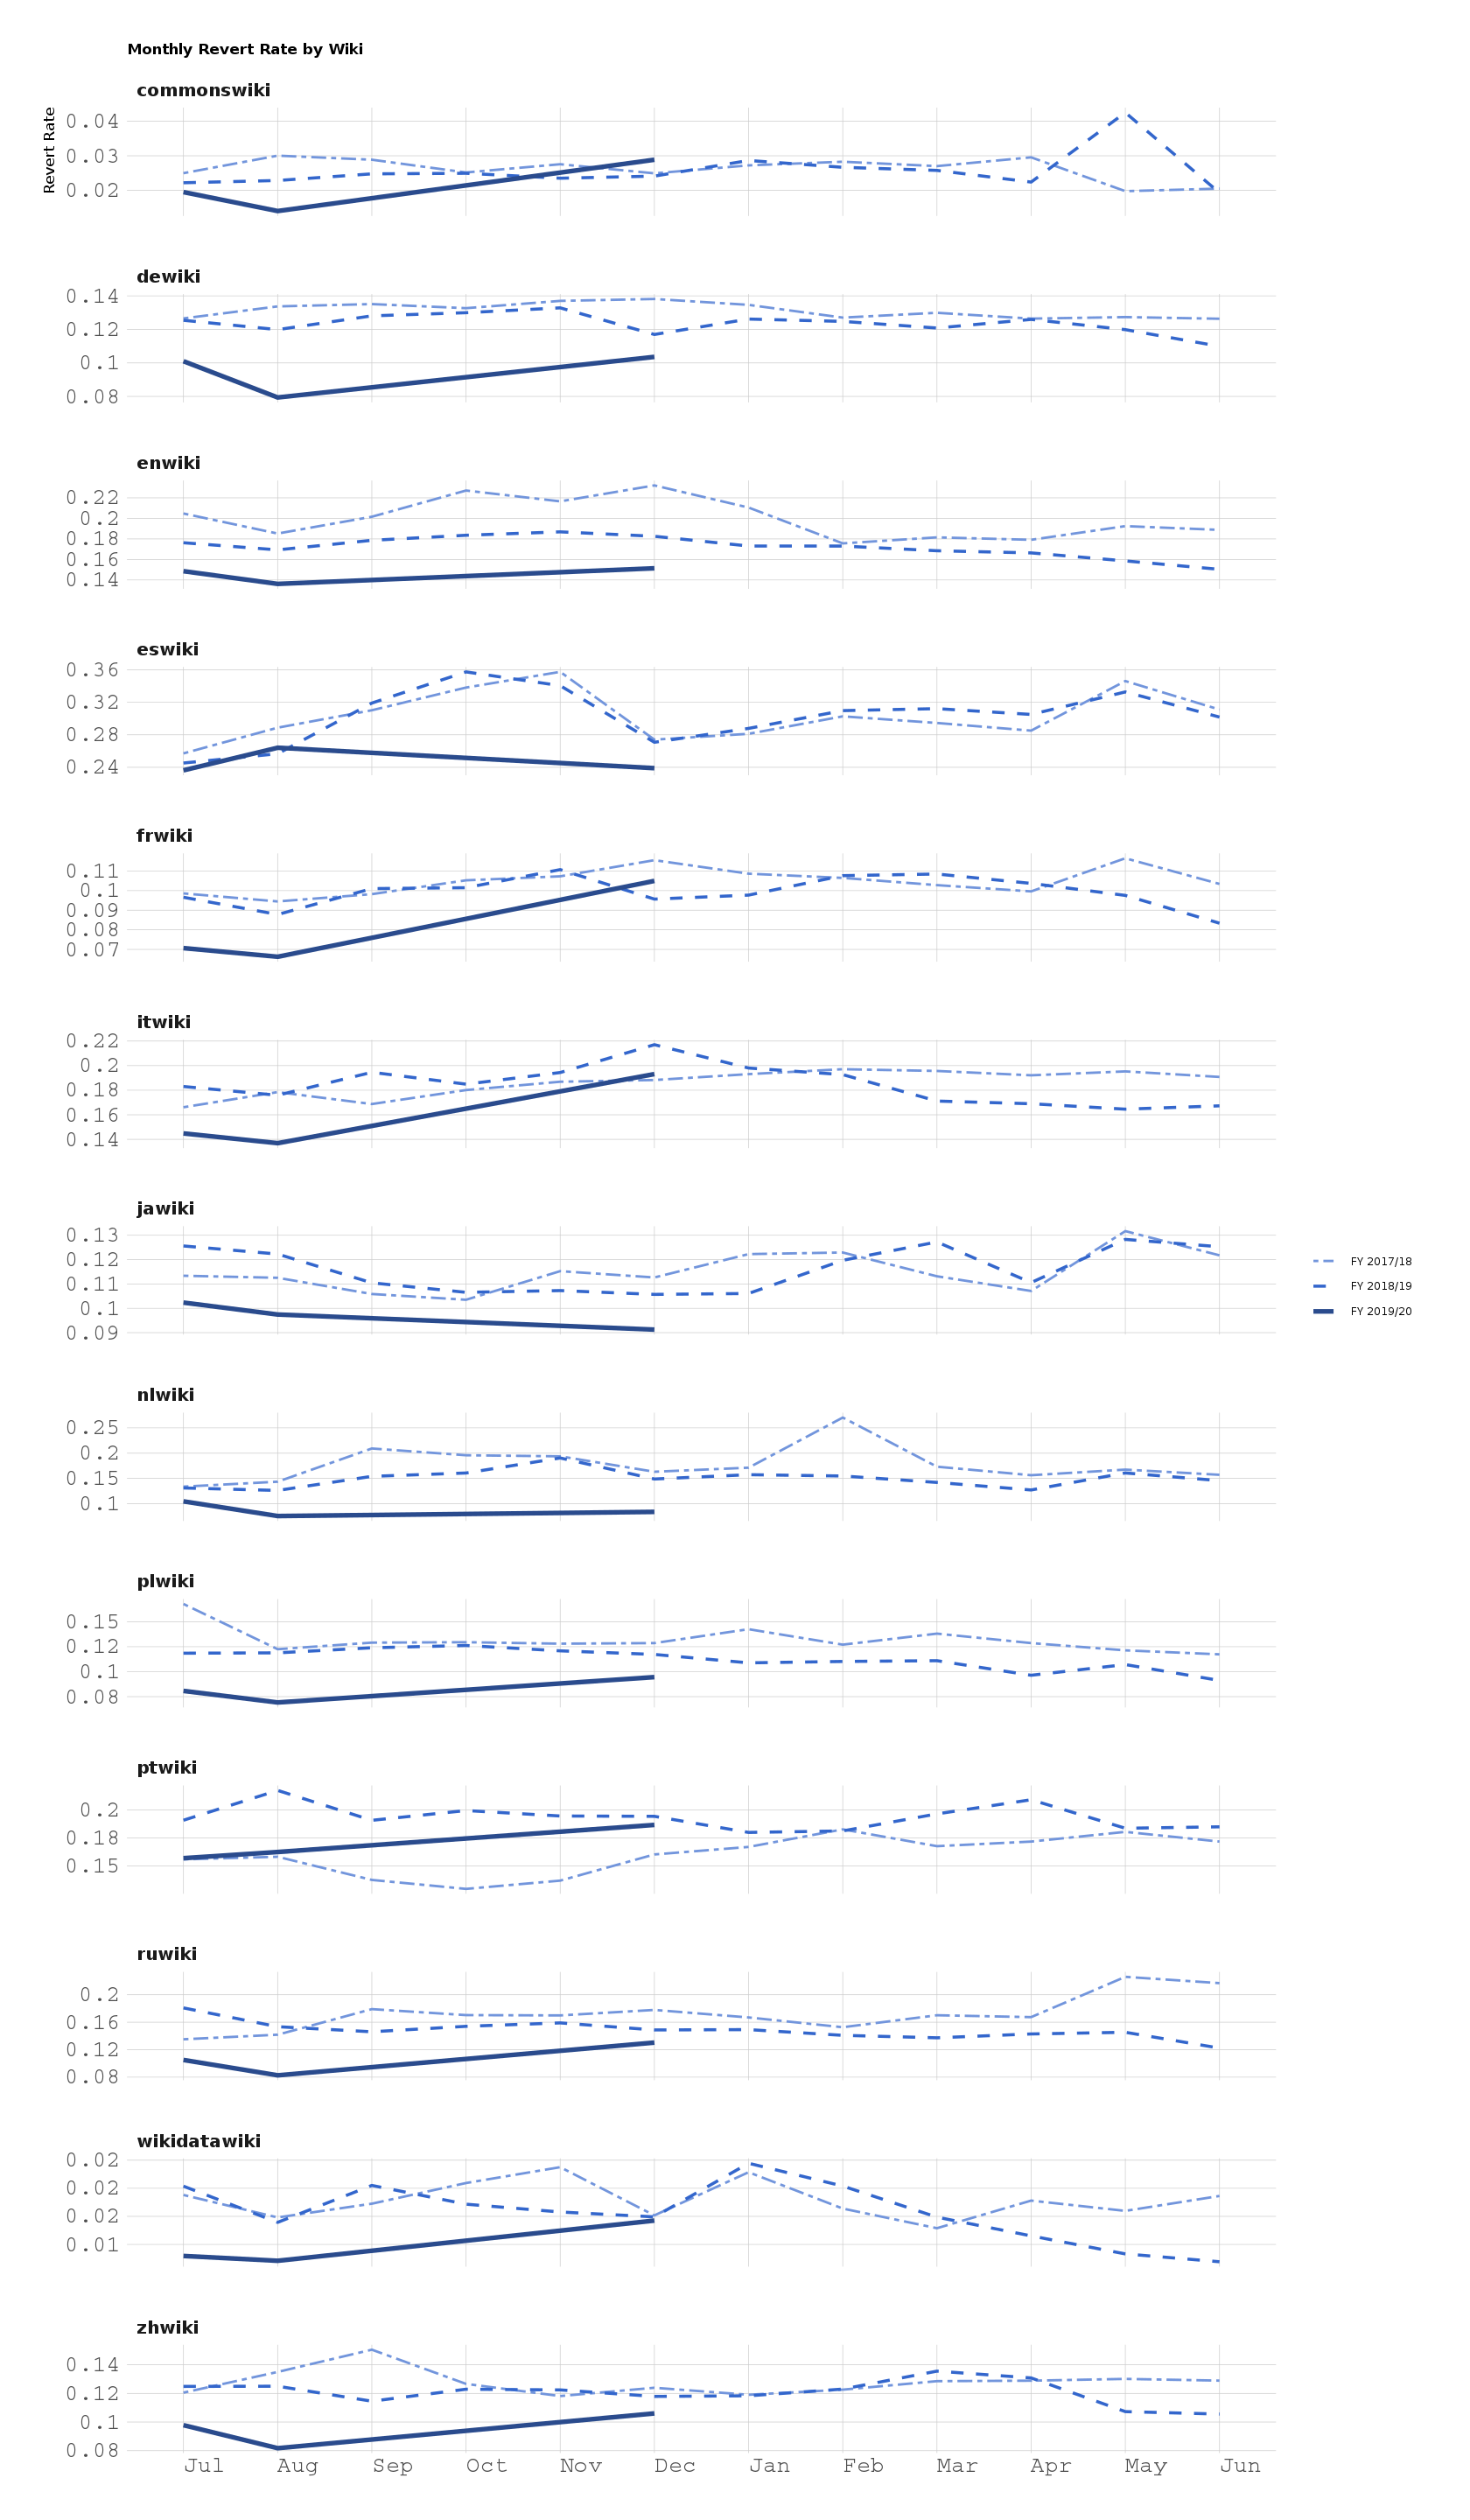

In [41]:
options(repr.plot.width = 14, repr.plot.height = 24)

revert_rate_fy %>%
    ggplot(aes(x = MonthN)) +
    geom_line(aes(x = MonthN, y = revert_rate, group=fiscal_year, color = fiscal_year,size=fiscal_year,linetype = fiscal_year)) +  
    scale_size_manual(values = c(0.8,1,1.5)) +
    scale_color_manual(values = c("FY 2017/18" = "#7295dc", "FY 2018/19" = "#3366cc","FY 2019/20" = "#2a4b8d")) +
    scale_linetype_manual(values=c("twodash", "dashed","solid")) +
    scale_x_discrete(breaks = revert_rate_fy$MonthN, labels = revert_rate_fy$Month) +
    scale_y_continuous("Revert Rate", labels = polloi::compress) +
    hrbrthemes::theme_ipsum("DejaVu Sans", base_size = 16, strip_text_face = "bold", 
                            caption_size = 8, axis_title_size = 10, subtitle_size = 10) +
    facet_wrap(~ wiki_db, ncol = 1, scales = "free_y") +
    theme(axis.text=element_text( hjust = 0,size = 10,family="Courier"),
          axis.title.x=element_blank(),
          panel.grid = element_line("gray80"),
          plot.title = element_text(size = 10,hjust = 0,face= "bold"),
          legend.title = element_blank(),
          legend.text =element_text( hjust = 0.5,size = 8),
          panel.grid.minor.y = element_blank()) +
    labs(title = "Monthly Revert Rate by Wiki") 

By looking at projects, dewiki, enwiki, jawiki, plwiki, ruwiki, zhwiki and wikidata are showing a YoY big % drop in revert rate for past few months.

### Edits Count vs Reverts by Wiki

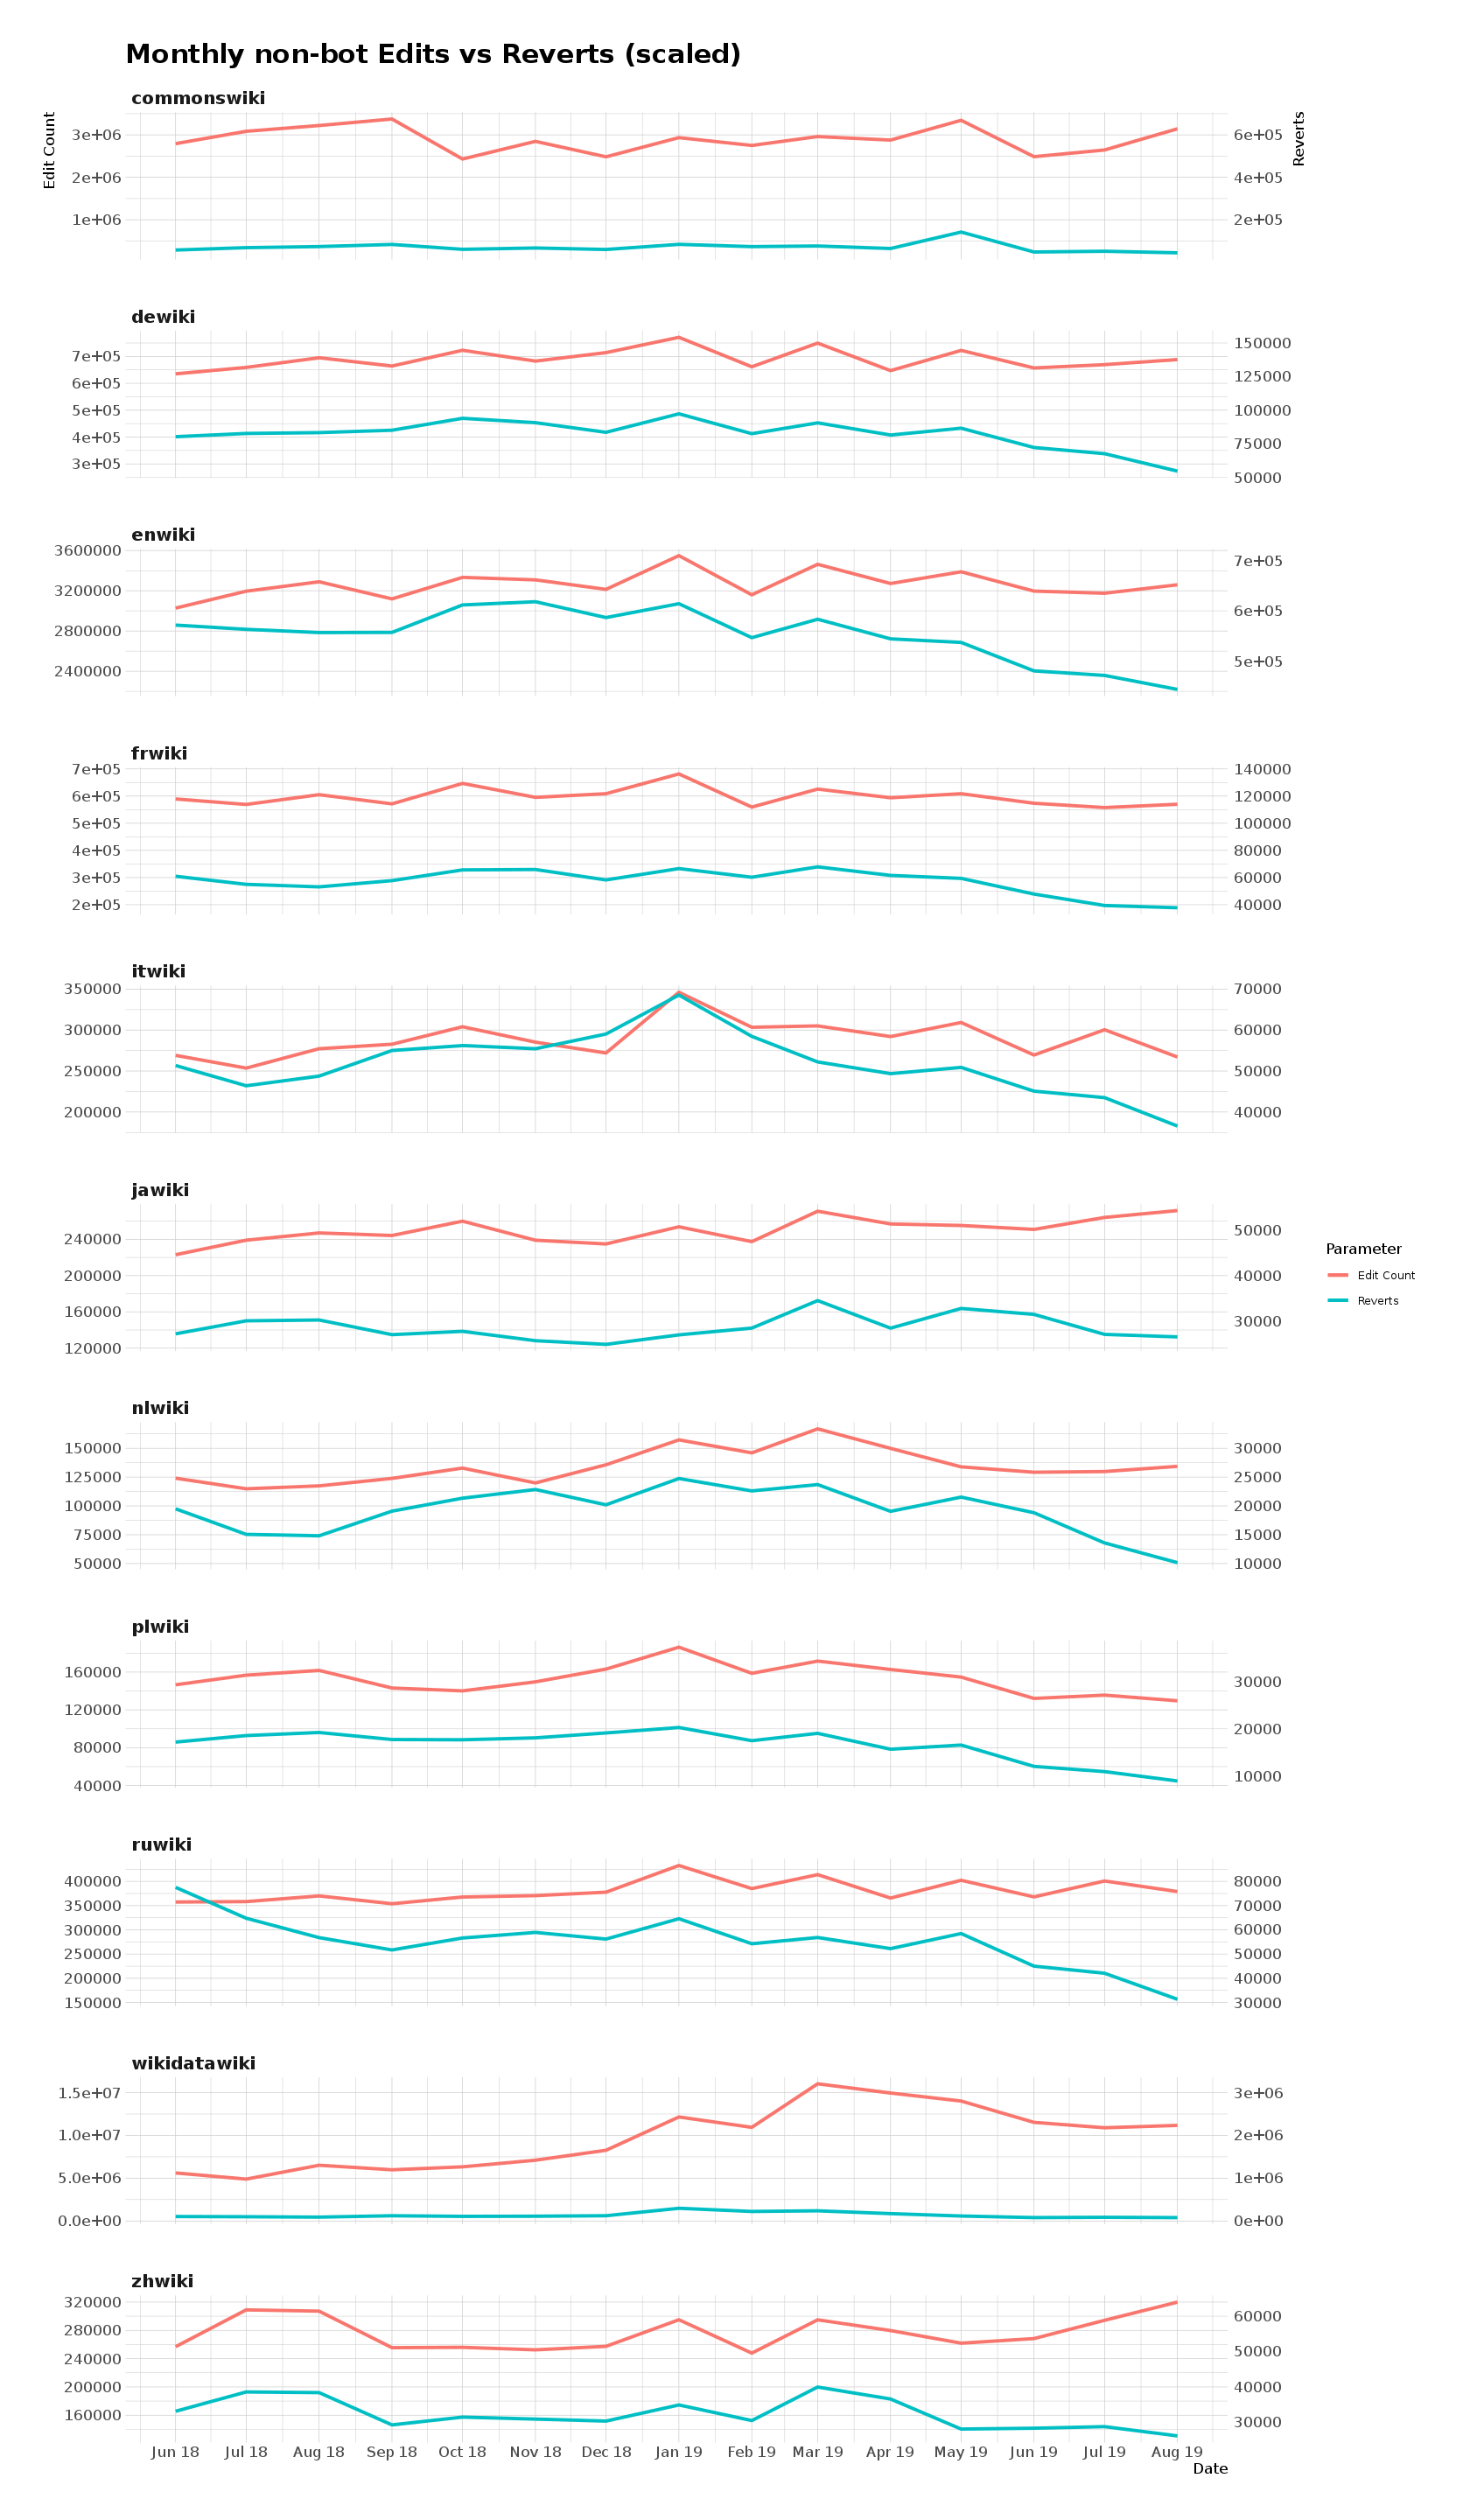

In [58]:
revert_wiki %>%
    filter(month >= '2018-06-01' & month <= '2019-09-01') %>%
    filter(wiki_db != 'eswiki' & wiki_db != 'ptwiki') %>% 
    group_by(month,wiki_db) %>%
    summarise(edits = sum(nonbot_edit),reverts = sum(revert))%>%
    arrange(month) %>%
    ggplot(aes(x = month)) + 
    geom_line(aes(y = edits, colour = "Edit Count"),size = 1.1) +
    scale_x_date("Date", labels = date_format("%b %y"), date_breaks = "1 months") +
    geom_line(aes(y = reverts*5, colour = "Reverts"),size = 1.1) + 
    scale_y_continuous(sec.axis = sec_axis(~./5, name = "Reverts"))  + 
    labs(y = "Edit Count", x = "Month", colour = "Parameter") + 
    facet_wrap(~ wiki_db, ncol = 1, scales = "free_y") +
    theme(axis.text=element_text( hjust = 0,size = 10,family="Courier"),
          axis.title.x=element_blank(),
          panel.grid = element_line("gray80"),
          plot.title = element_text(size = 8,hjust = 0,face= "bold"),
          legend.title = element_blank(),
          legend.text =element_text( hjust = 0.5,size = 8),
          panel.grid.minor.y = element_blank()) +
   hrbrthemes::theme_ipsum("DejaVu Sans", base_size = 10, strip_text_face = "bold", 
                            caption_size = 8, axis_title_size = 10, subtitle_size = 10) +
   labs( title = "Monthly non-bot Edits vs Reverts (scaled)")

The drop in recent revert rate is correlated to (non-bot) edit increases only in wikidata and commons. For some other projects (dewiki,enwiki,frwiki,itwiki,nlwiki,plwiki,ruwiki,zhwiki), the increases in (non-bot) edits are small over time, and the drop in reverts result in the drop in revert rate.

### Revert Editors

In [6]:
query <- "
SELECT
    DATE_FORMAT(event_timestamp, 'YYYY-MM-01') AS month,
    wiki_db,
    event_user_id AS user_id,
    max(event_user_text) AS user_name,
    MAX(SIZE(event_user_is_bot_by) > 0 or SIZE(event_user_is_bot_by_historical) > 0) AS bot_by_group,
    DATE_FORMAT(MIN(event_user_creation_timestamp), 'YYYY-MM-01') AS register,
    COUNT(*) AS revert
FROM wmf.mediawiki_history
WHERE
    event_entity = 'revision'
    AND event_type = 'create'
    AND event_timestamp >= '2017-07' 
    AND event_timestamp <= '2019-08'
    AND snapshot = '2019-08'
    AND revision_is_identity_revert = TRUE
    AND wiki_db in ('enwiki','commonswiki','wikidatawiki', 'dewiki', 'frwiki', 'ruwiki','itwiki','zhwiki', 'plwiki', 'nlwiki')
    
GROUP BY DATE_FORMAT(event_timestamp, 'YYYY-MM-01'),wiki_db,event_user_id
"

In [7]:
revert_editor <- wmf::query_hive(query)

In [8]:
revert_editor$month <- as.Date(revert_editor$month, format = "%Y-%m-%d")
revert_editor$register <- as.Date(revert_editor$register, format = "%Y-%m-%d")

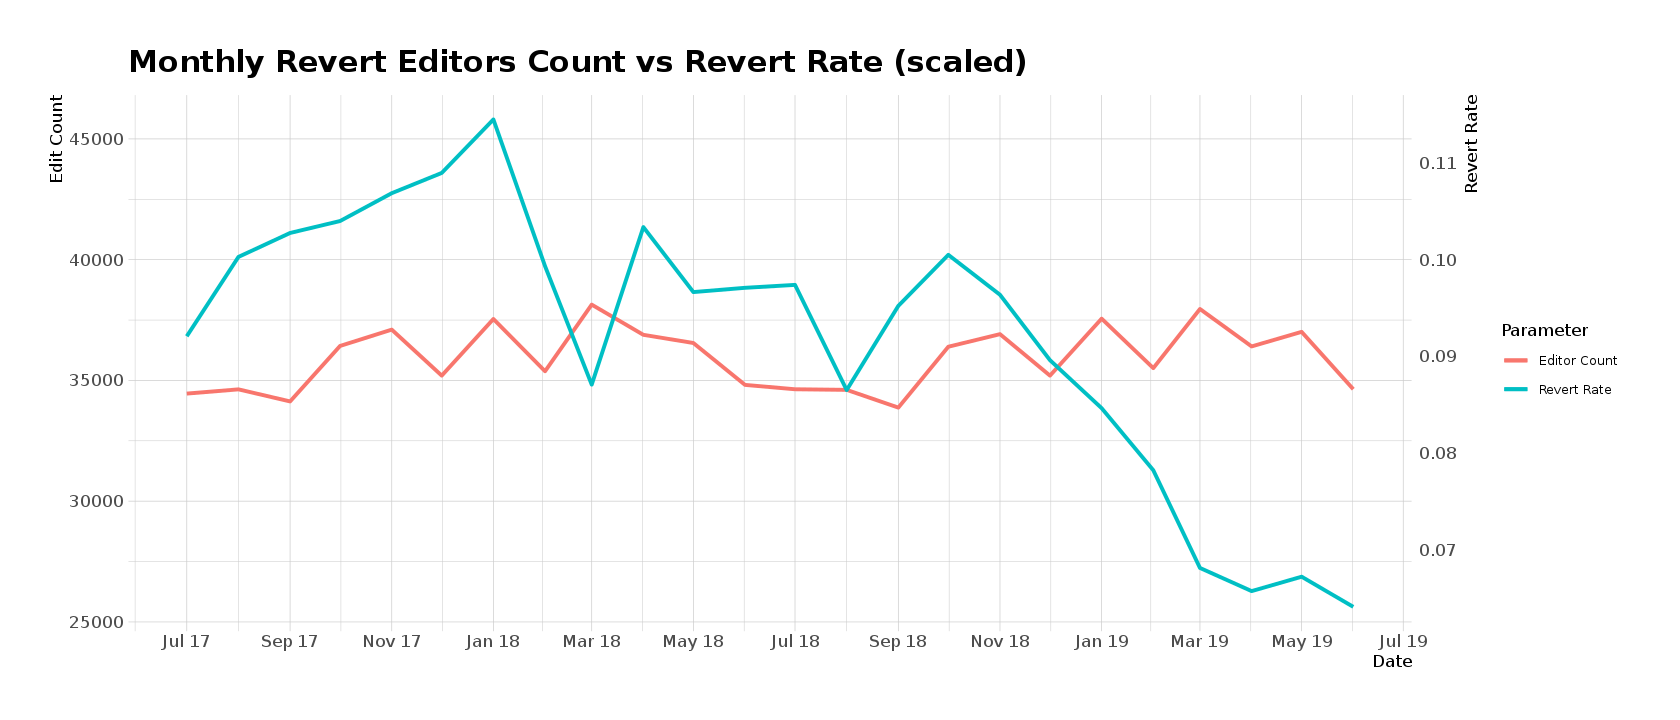

In [40]:
options(repr.plot.width = 14, repr.plot.height = 6)

revert_editor %>%
    filter(month <= '2019-06-01') %>%
    filter(bot_by_group == 'false') %>%
    group_by(month) %>%
    summarise(editor_count = n_distinct(user_name)) %>%
    left_join (revert_rate_month, by = "month")  %>%
    ggplot( aes(x = month)) + 
    geom_line(aes(y = editor_count, colour = "Editor Count"),size = 1.1) +
    scale_x_date("Date", labels = date_format("%b %y"), date_breaks = "2 months") +
    geom_line(aes(y = revert_rate*400000, colour = "Revert Rate"),size = 1.1) + 
    scale_y_continuous(sec.axis = sec_axis(~./400000, name = "Revert Rate"))  + 
    labs(y = "Edit Count", x = "Month", colour = "Parameter") + 
    theme(axis.text=element_text( hjust = 0,size = 10,family="Courier"),
          axis.title.x=element_blank(),
          panel.grid = element_line("gray80"),
          plot.title = element_text(size = 8,hjust = 0,face= "bold"),
          legend.title = element_blank(),
          legend.text =element_text( hjust = 0.5,size = 8),
          panel.grid.minor.y = element_blank()) +
   hrbrthemes::theme_ipsum("DejaVu Sans", base_size = 10, strip_text_face = "bold", 
                            caption_size = 8, axis_title_size = 10, subtitle_size = 10) +
   labs( title = "Monthly Revert Editors Count vs Revert Rate (scaled)")

#### Revert Editors by wiki

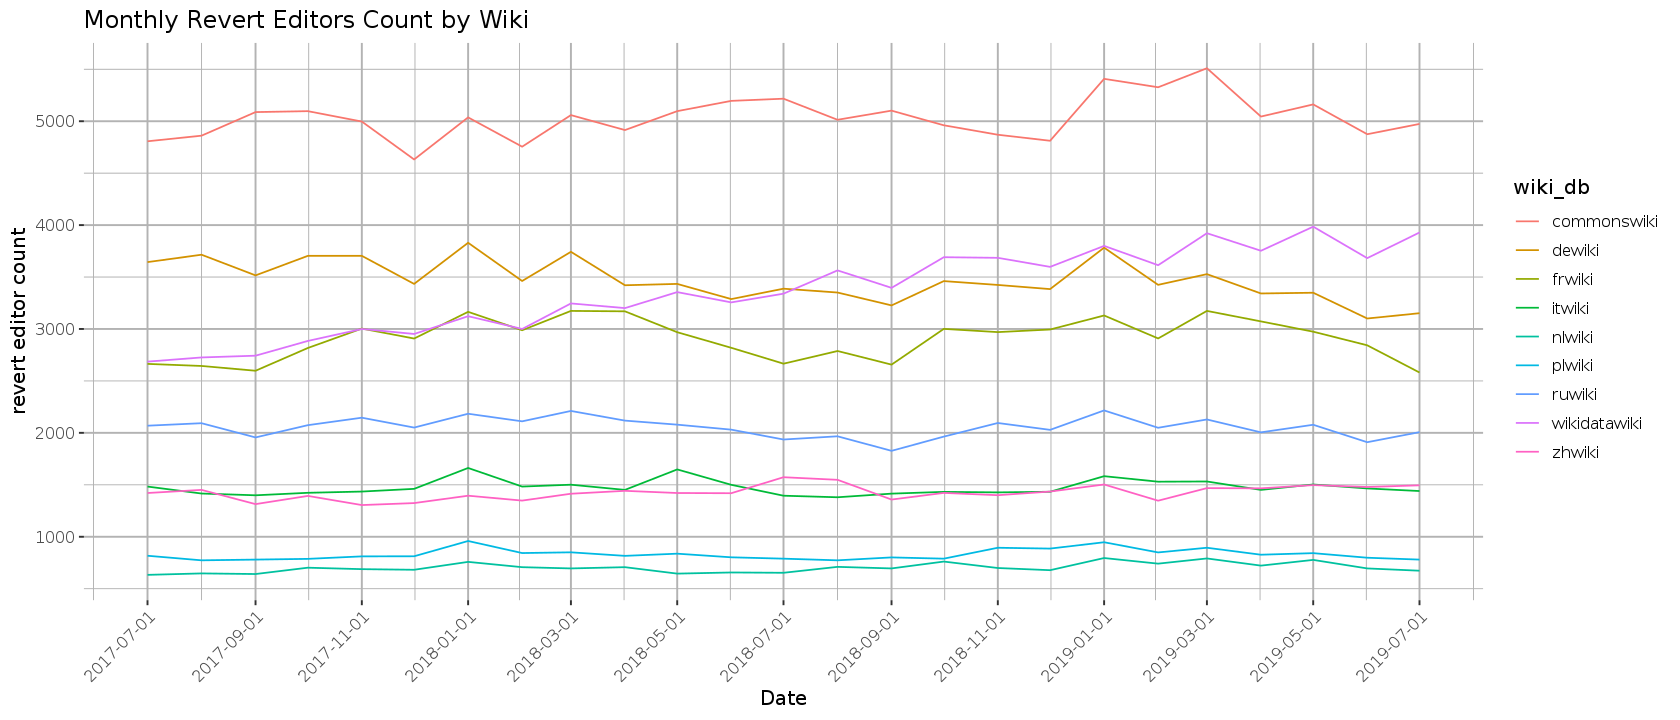

In [42]:
 
revert_editor %>%
    filter(month <= '2019-08-01') %>%
    filter(month >= '2017-07-01') %>%
    filter(bot_by_group == 'false') %>%
    filter(wiki_db != 'enwiki') %>%
    group_by(month,wiki_db) %>%
    summarise(editor_count = n_distinct(user_name)) %>%
    ggplot(aes(x=month, y =editor_count, color = wiki_db)) +  
    geom_line() +
    scale_y_continuous("revert editor count") +
    scale_x_date("Date", labels = date_format("%Y-%m-%d"), date_breaks = "2 month")+
    labs(title = "Monthly Revert Editors Count by Wiki") +
    ggthemes::theme_tufte(base_size = 12, base_family = "Gill Sans") +
    theme(axis.text.x=element_text(angle = 45, hjust = 1),
        panel.grid = element_line("gray70"))


#### New and returning Editors by wiki

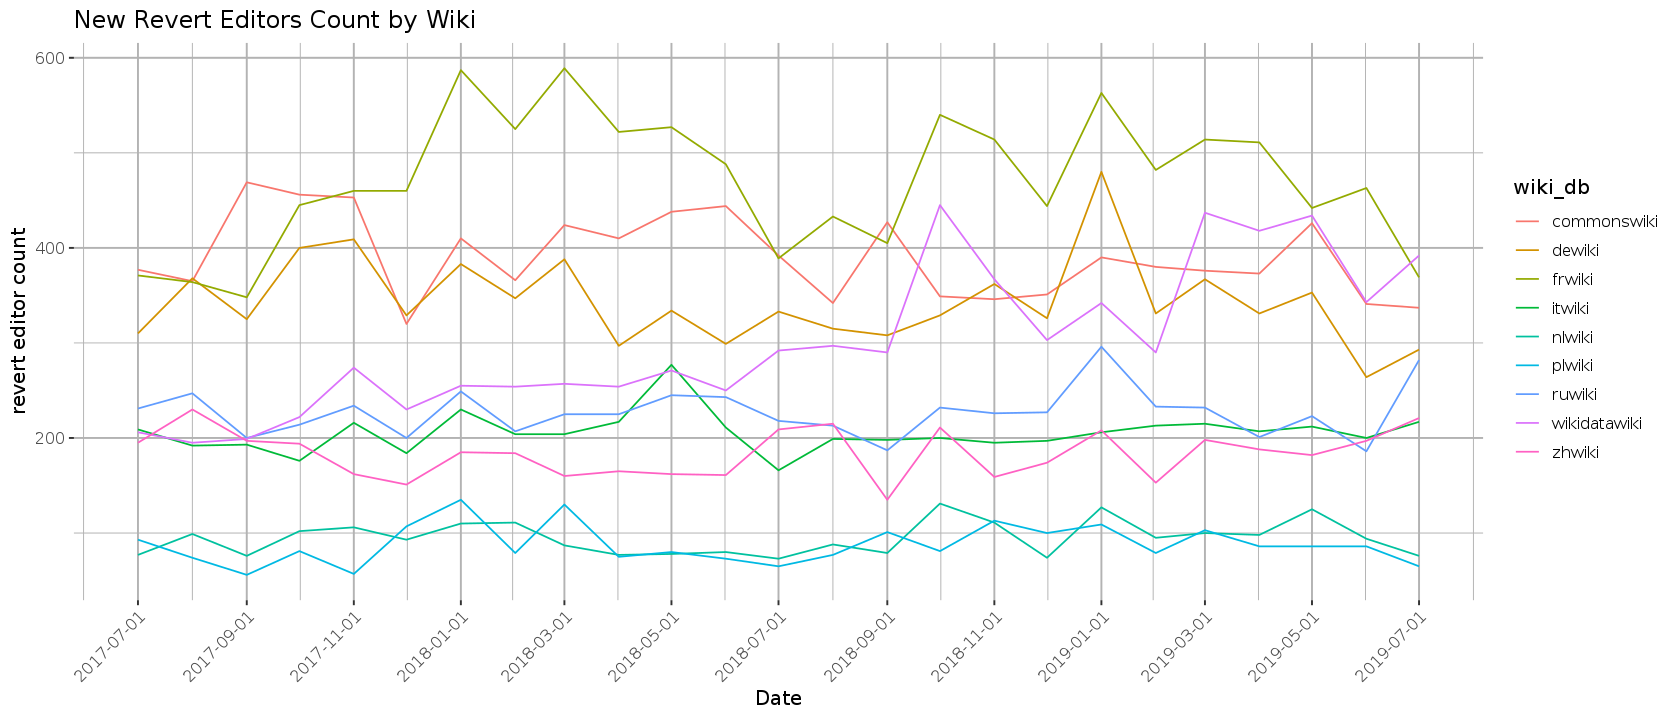

In [44]:
##new editors

revert_editor %>%
    filter(month <= '2019-08-01') %>%
    filter(month >= '2017-07-01') %>%
    filter(month <= register) %>%
    filter(bot_by_group == 'false') %>%
    filter(wiki_db != 'enwiki') %>%
    #filter(user_ == 'NULL') %>%
    group_by(month,wiki_db) %>%
    summarise(editor_count = n_distinct(user_name)) %>%
    ggplot(aes(x=month, y =editor_count, color = wiki_db)) +  
    geom_line() +
    scale_y_continuous("revert editor count") +
    scale_x_date("Date", labels = date_format("%Y-%m-%d"), date_breaks = "2 month")+
    labs(title = "New Revert Editors Count by Wiki") +
    ggthemes::theme_tufte(base_size = 12, base_family = "Gill Sans") +
    theme(axis.text.x=element_text(angle = 45, hjust = 1),
        panel.grid = element_line("gray70"))



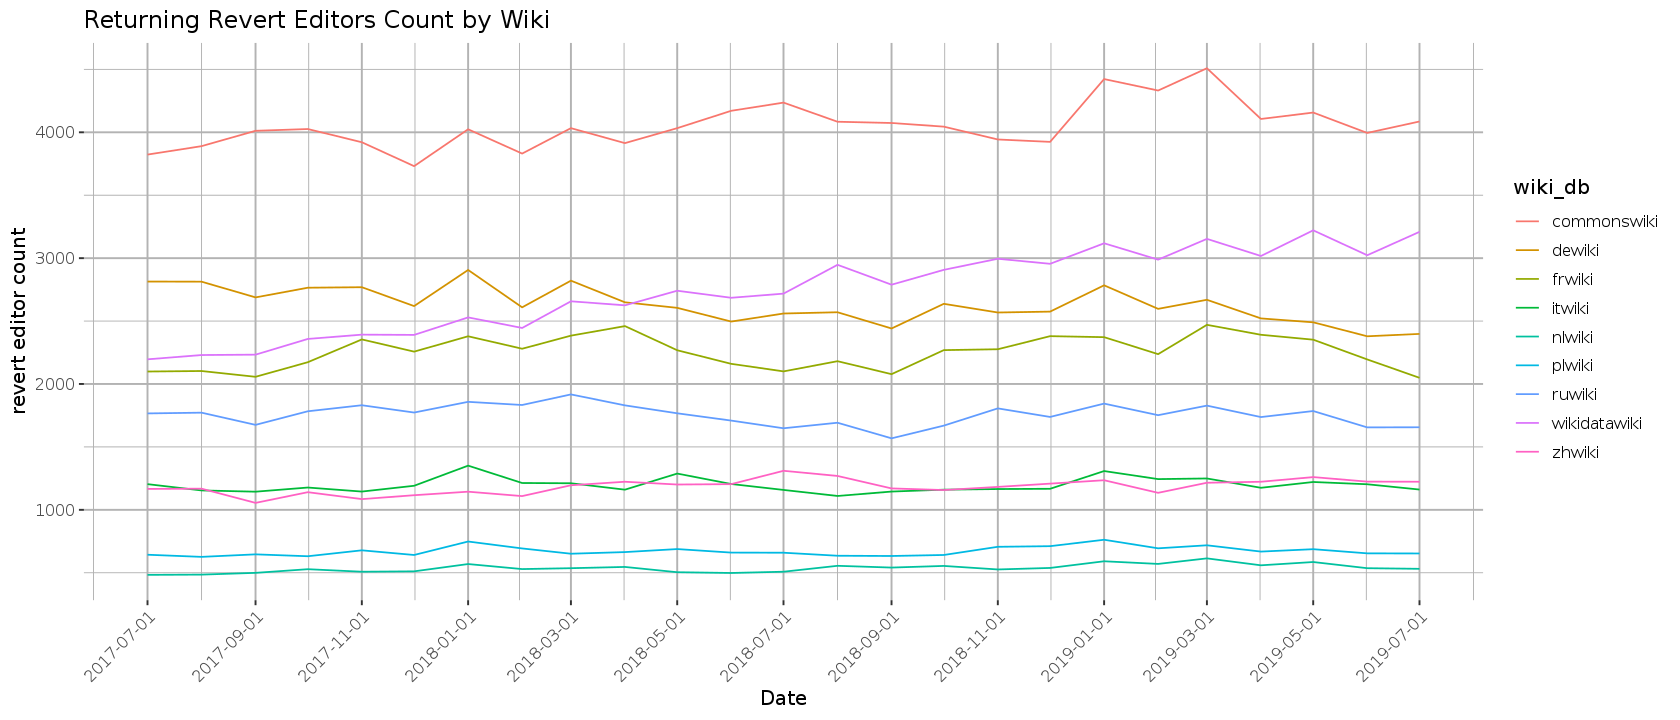

In [45]:
## returning editors
revert_editor %>%
    filter(month <= '2019-08-01') %>%
    filter(month >= '2017-07-01') %>%
    filter(month > register) %>%
    filter(bot_by_group == 'false') %>%
    filter(wiki_db != 'enwiki') %>%
    group_by(month,wiki_db) %>%
    summarise(editor_count = n_distinct(user_name)) %>%
    ggplot(aes(x=month, y =editor_count, color = wiki_db)) +  
    geom_line() +
    scale_y_continuous("revert editor count") +
    scale_x_date("Date", labels = date_format("%Y-%m-%d"), date_breaks = "2 month")+
    labs(title = "Returning Revert Editors Count by Wiki") +
    ggthemes::theme_tufte(base_size = 12, base_family = "Gill Sans") +
    theme(axis.text.x=element_text(angle = 45, hjust = 1),
        panel.grid = element_line("gray70"))


By looking at the number of users who make reverts overtime by tenue and by project, we didn's see a signigicant change in number of edtitors.

### Micro Contribution

### Revert Deleted